In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pipeline as pi
from matplotlib import gridspec

This is a notebook to reproduce the figures of the report

# Figure 1

## Import the datasets

In [2]:
df_comp = pd.read_csv('../data/results/figures/chanvese/tricho_wounded_chanvese_fig.csv',sep=',')
df_prepro = pd.read_csv('../data/results/figures/chanvese/tricho_wound_preprocessed_otsu_masked_fig.csv',sep=',')
df_wound_comp = pd.read_csv('../data/results/figures/chanvese/wound_placozoan-movie_wound_masked_chanvese.csv',sep=';')
df_wound_prepro = pd.read_csv('../data/results/figures/chanvese/wound_tricho_wound_preprocessed_otsu_masked.csv',sep=';')

In [122]:
missing_planes_pipeline = [x for x in df_comp.label.values if x not in df_wound_prepro.label.values]
missing_planes_raw = [x for x in df_comp.label.values if x not in df_wound_comp.label.values]

## Building the Figure

In [ ]:
sns.set_context('paper') # set context for plotting

fig = plt.figure(figsize=(12,8)) # create the canvas size

gs = gridspec.GridSpec(4, 3) # make it as a grid 


# build grid
ax = np.array([fig.add_subplot(gs[0:2,0]),fig.add_subplot(gs[2:4,0:3]),
              fig.add_subplot(gs[0:2,1]),fig.add_subplot(gs[0:2,2])])
#order: top left, bottom plot, top middle,top right


# Plot and put each plot in corresponding subplot

# top left

sns.lineplot(data=df_comp, x=df_comp.index.values,y='area',ax = ax[0],label='Manually contrasted')
sns.lineplot(data=df_prepro, x=df_prepro.index.values,y='area',ax = ax[0],label='Processed')

#bottom plot

sns.scatterplot(x = df_wound_comp.label.values,y = df_wound_comp.area,marker = '.'
                ,linewidth = 0,label='Unprocessed',zorder=1,ax = ax[1])

sns.scatterplot(x = df_wound_prepro.label.values,y = df_wound_prepro.area,marker = '.'
                ,linewidth = 0,label='Preprocessed',zorder=1,ax = ax[1])

sns.scatterplot(x = df_wound_comp.label.values , y = -1300,marker='|'
                ,label=f'Planes unprocessed, n = {len(df_wound_comp.label.values)}',ax = ax[1])

sns.scatterplot(x = df_wound_prepro.label.values , y = -800,marker='|'
                ,label=f'Planes preprocessed, n = {len(df_wound_prepro.label.values)}',ax = ax[1])

# top middle

sns.lineplot(data=df_comp, x=df_comp.index.values,y='perimeter',ax = ax[2],label='Manually contrasted')
sns.lineplot(data=df_prepro, x=df_prepro.index.values,y='perimeter',ax = ax[2],label='Processed')

# top right

sns.lineplot(data=df_comp, x=df_comp.index.values,y='eccentricity',ax = ax[3],label='Manually contrasted')
sns.lineplot(data=df_prepro, x=df_prepro.index.values,y='eccentricity',ax = ax[3],label='Processed')

ax[1].set_xlim(ax[0].get_xlim()[0],ax[0].get_xlim()[1])
    
# Add the letter for panel

letter = ['A','D','B','C']

for i in range(4): 
    if i != 1:
        ax[i].text(-0.1,1.01, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')
    else:
        ax[i].text(-0.027,1.01, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')

plt.tight_layout()
#plt.savefig('../data/results/figures/report/fig1_replot.svg',dpi=300)
plt.show()

# Figure 2

In [3]:
df_drift = pd.read_csv('../data/results/figures/report/df_drift.csv')
df_global_drift = pd.read_csv('../data/results/figures/report/drift_all_planes.csv')

In [ ]:
sns.scatterplot(data=df_global_drift,x='Unnamed: 0',y='Drift',hue='Color',linewidth=0)

In [143]:
def eucldist(df_t,points):
    '''
    Function to compute the eucledian distance
    
    Parameters
    ----------
    df_t : dataframe
        position of te algae at frame t.
    df_t1 : dataframe
        position of te algae at time t plus 1.
    points : list
        the position in the dataframe where to compute the distance.

    Returns
    -------
    dist : int
        the eucledian distance between the 2 points.

    '''
    one = df_t.iloc[points[0]]
    two = df_t.iloc[points[1]]
    diff = (two['centroid-1']-one['centroid-1'])**2 + (two['centroid-0']-one['centroid-0'])**2
    dist = np.sqrt(diff)
    
    return dist

def clean_results(df_org,df_drift,window_size = 1):
    '''
    Parameters
    ----------
    dft : Dataframe
        Dataframe of the organism properties.
    df_drift : Dataframe
        Dataframe of the drift moments.

    Returns
    -------
    dft : Dataframe
        Dataframe of the organism properties with corrected drift and interpolation.

    Worklow
    -------
    
    First remove the laser time point (might create an odd value) for that I just replace the whole line by the one before
    Then the goal is to correct the drift for that:
        -Loop over all planes 
        - if plane in the drift dataframe then correct depending on the corrdinate and the orientation of the movement
    
    TO DO:
        optimize this function that might take a while for big dataframes. Might be a better way to correct the dataframe
        
    '''
    dft = df_org.copy()
    
    for i in dft.index.values:
        index = i 
        if index in df_drift.end.values:
            if df_drift[df_drift.end == index].direction.values == 0:
                
                if df_drift[df_drift.end == index].coord.values == 'y':
    
                    dft.loc[index,'centroid-0'] = dft.loc[index,'centroid-0'] - np.abs(df_drift[df_drift.end == index].displacement.values)
                
                else:
                    
                    dft.loc[index,'centroid-1'] = dft.loc[index,'centroid-1'] - np.abs(df_drift[df_drift.end == index].displacement.values)
                    
            else:
                
                if df_drift[df_drift.end == index].coord.values == 'y':
                    
                    dft.loc[index,'centroid-0'] = dft.loc[index,'centroid-0'] + np.abs(df_drift[df_drift.end == index].displacement.values)
                
                else:
                    
                    dft.loc[index,'centroid-1'] = dft.loc[index,'centroid-1'] + np.abs(df_drift[df_drift.end == index].displacement.values)
    return dft

In [144]:
disp_pipe = [0]
disp_comp = [0]

for i in range(len(df_comp.index.values)-1):
    disp_pipe.append(eucldist(df_prepro,[i,i+1]))
    disp_comp.append(eucldist(df_comp,[i,i+1]))

In [145]:
df_pip = df_prepro.copy()
df_compa = df_comp.copy()

In [146]:
df_pip.loc[:,'displacement'] = disp_pipe
df_compa.loc[:,'displacement'] = disp_comp

In [147]:
fmin = 700 
fmax = 800 

df_pip = df_pip.iloc[fmin:fmax]
df_compa = df_compa.iloc[fmin:fmax]

In [148]:
for i in df_pip.index.values:
    df_pip.loc[i,'displacement'] = df_pip.loc[i,'displacement']/np.max(df_pip.displacement)
    df_compa.loc[i,'displacement'] = df_compa.loc[i,'displacement']/np.max(df_compa.displacement)

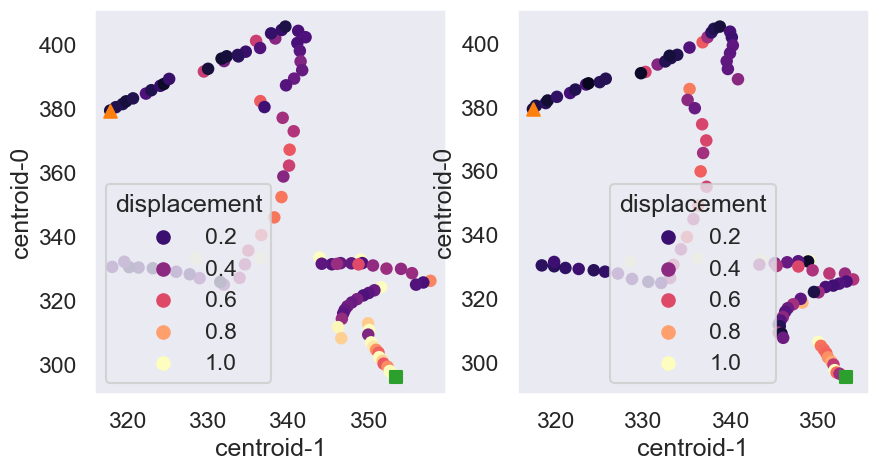

In [149]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

sns.scatterplot(data = df_pip , y = 'centroid-0',x = 'centroid-1',marker="o"
                ,hue='displacement',palette="magma",linewidth=0,ax=ax[1]
               ,hue_norm = (0,1))
ax[1].scatter(y = df_pip['centroid-0'].values[0],x = df_pip['centroid-1'].values[0]
                ,marker="^",label='begining')
ax[1].scatter(y = df_pip['centroid-0'].values[-1],x = df_pip['centroid-1'].values[-1]
                ,marker="s",label='end')


sns.scatterplot(data=df_compa,y = 'centroid-0',x = 'centroid-1',marker="o"
                ,hue='displacement',palette="magma",linewidth=0,ax=ax[0],
                hue_norm = (0,1))
ax[0].scatter(y = df_compa['centroid-0'].values[0],x = df_compa['centroid-1'].values[0]
                ,marker="^",label='begining')
ax[0].scatter(y = df_compa['centroid-0'].values[-1],x = df_compa['centroid-1'].values[-1]
                ,marker="s",label='end')



In [23]:
dx2 = []
dy2 = []


e = pd.read_csv('../data/pos_alg_figure_bis.csv',sep=',')
e = e[['Y','X','Slice']]

for j in range(1,len(e.index)):
    if e.iloc[j].Slice == e.iloc[j-1].Slice + 1:
        dx2.append(pi.distance(e,[j-1,j])[0])
        dy2.append(pi.distance(e,[j-1,j])[1])      
e

,Y,X,Slice
0,435.0,46.0,725
1,428.0,47.0,726
2,422.0,47.0,727
3,416.0,47.0,728
4,409.0,46.0,729
5,402.0,47.0,730
6,396.0,47.0,731
7,388.0,47.0,732
8,379.0,46.0,733
9,371.0,47.0,734


In [24]:
disp = []

for i in range(len(dx2)):
    if np.abs(dx2[i]) > np.abs(dy2[i]):
        disp.append(int(dx2[i]))
    else:
        disp.append(int(dy2[i]))
disp

[-7,
 -6,
 -6,
 -7,
 -7,
 -6,
 -8,
 -9,
 -8,
 -10,
 -9,
 -11,
 -9,
 -9,
 -9,
 -11,
 -8,
 -9,
 -5,
 -7,
 -3,
 2,
 -3,
 -8,
 -7,
 -6,
 -8,
 -9,
 -7,
 -6,
 -8,
 -8,
 -7,
 -8,
 -7,
 -7,
 -8,
 -6,
 -7,
 -8,
 -6]

In [25]:
df_drift_true = df_drift.copy()

In [26]:
df_drift_true.loc[:,'displacement'] = np.abs(disp)
df_drift_true

C:\Users\nessl\AppData\Local\Temp\ipykernel_2348\1501475803.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_drift_true.loc[:,'displacement'] = np.abs(disp)


,Unnamed: 0,start,end,direction,coord,displacement
0,0,725,726,0,y,7
1,1,726,727,0,y,6
2,2,727,728,0,y,6
3,3,728,729,0,y,7
4,4,729,730,0,y,7
5,5,730,731,0,y,6
6,6,731,732,0,y,8
7,7,732,733,0,y,9
8,8,733,734,0,y,8
9,9,734,735,0,y,10


In [155]:
df_true = clean_results(df_prepro,df_drift_true)

In [156]:
distance_t = [0]
for i in range(len(df_true.index.values)-1):
    distance_t.append(eucldist(df_true,[i,i+1]))
    
df_true.loc[:,'displacement'] = distance_t

df_tr = df_true.iloc[fmin:fmax]

for i in df_tr.index.values:
    df_tr.loc[i,'displacement'] = df_tr.loc[i,'displacement']/np.max(df_tr.displacement)

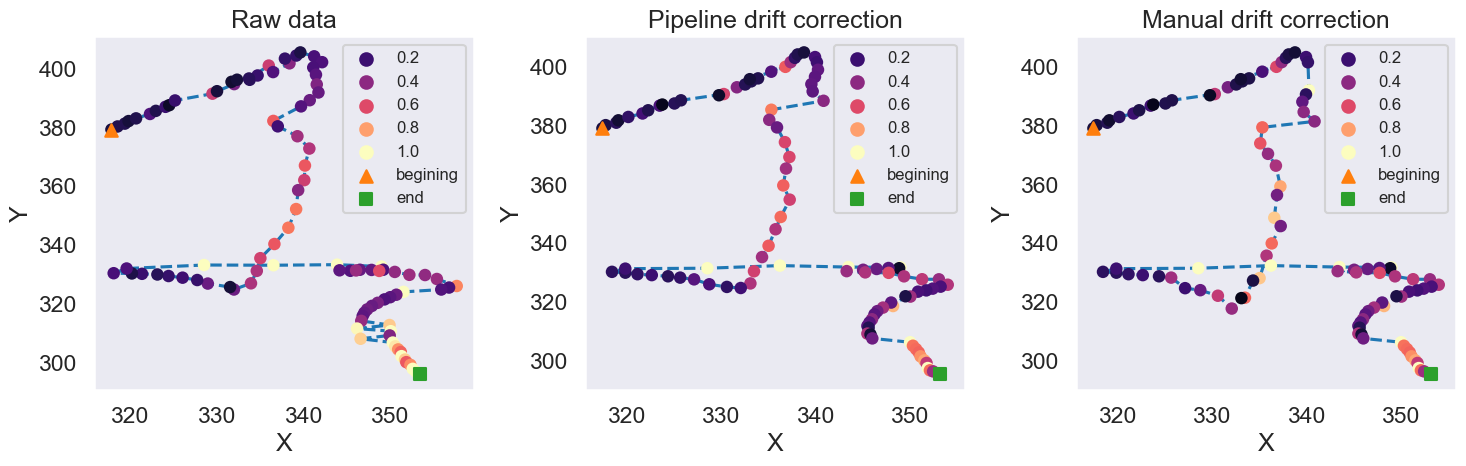

In [157]:
sns.set_style("dark")
sns.set_context('talk')

fig,ax = plt.subplots(1,3,figsize=(15,5))
df_l = [df_compa,df_pip,df_tr]
leg = ['Raw data','Pipeline drift correction','Manual drift correction']

for ax,df,name in zip(ax,df_l,leg):
    #Trajectory
    sns.scatterplot(data=df,y = 'centroid-0',x = 'centroid-1',marker="o"
                ,hue='displacement',palette="magma",linewidth=0,ax=ax,
                hue_norm = (0.,1),zorder=1)
    #Begining point
    ax.scatter(y = df['centroid-0'].values[0],x = df['centroid-1'].values[0]
                ,marker="^",label='begining',zorder=2)
    #End point
    ax.scatter(y = df['centroid-0'].values[-1],x = df['centroid-1'].values[-1]
                ,marker="s",label='end',zorder=2)
    #Trajectoy (line)
    ax.plot(df['centroid-1'],df['centroid-0'],color='tab:blue',linestyle='--'
           ,zorder=0)
    #Style
    ax.legend(prop={'size': 12})
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    ax.set_title(name)

plt.tight_layout()

# Figure 3

In [19]:
df_new_segm = pd.read_csv('../data/new_movies/results/tables/props_19102022_16h02_1.csv')
df_drift_ns = pd.read_csv('../data/new_movies/results/tables/drift_19102022_16h02_1.csv')
df_postpro = pi.clean_results(df_new_segm,df_drift_ns,window_size=3)

<AxesSubplot: >

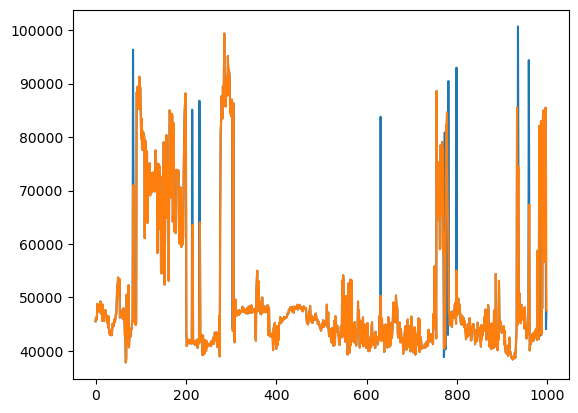

In [20]:
df_new_segm.area.plot()
df_postpro.area.plot()

In [35]:
df_error = df_drift.copy()

In [36]:
df_error.loc[:,'error'] = df_drift_true.loc[:,'displacement'] - df_drift.loc[:,'displacement']
df_error.loc[:,'error_abs'] = np.abs(df_drift_true.loc[:,'displacement'] - df_drift.loc[:,'displacement'])


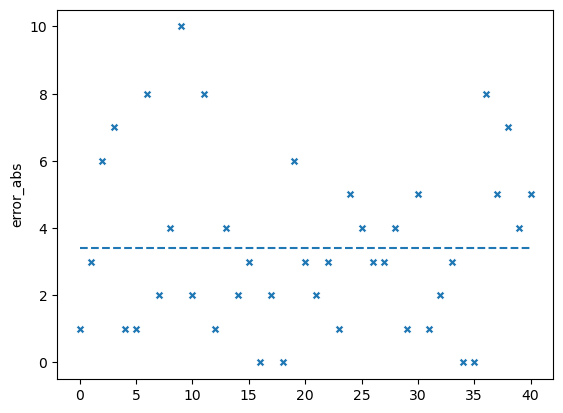

In [51]:
sns.scatterplot(data=df_error,x=df_error.index.values,y="error_abs",marker='X')
plt.hlines(df_error.error_abs.mean(),0,40,linestyle='--')

<AxesSubplot: >

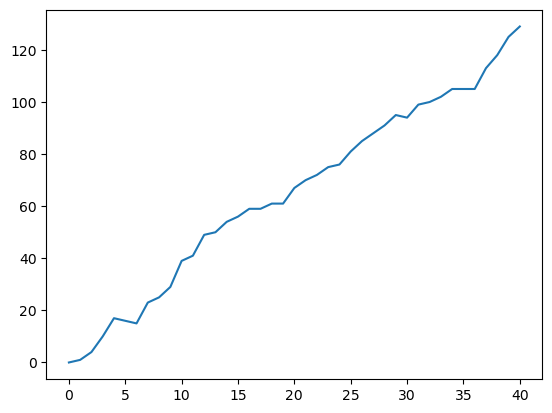

In [54]:
sns.lineplot([sum(df_error.error.values[0:x]) for x in range(len(df_error.error.values))])

In [ ]:
sns.set_context('paper') # set context for plotting

fig = plt.figure(figsize=(12,8)) # create the canvas size

gs = gridspec.GridSpec(2, 2) # make it as a grid 


# build grid
ax = np.array([fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,0:2])])

# panel A

sns.scatterplot(data=df_error,x=df_error.index.values,y="error_abs",marker='X',ax = ax[0])
ax[0].hlines(df_error.error_abs.mean(),0,40,linestyle='--')

# panel B

sns.lineplot([sum(df_error.error.values[0:x]) for x in range(len(df_error.error.values))],ax=ax[1])

# panel C

pixel_size =2.6 # in microns 

sns.lineplot(x=df_new_segm.index.values,y=df_new_segm.area.values*pixel_size*pixel_size,ax=ax[2])
sns.lineplot(x=df_postpro.index.values,y=df_postpro.area.values*pixel_size*pixel_size,ax=ax[2])

# Add the letter for panel

letter = ['A','B','C']

for i in range(3): 
    if i != 2:
        ax[i].text(-0.05,1.01, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')
    else:
        ax[i].text(-0.027,1.01, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')

# customization

ax[0].set_ylabel('$|Error|$')
ax[1].set_ylabel('Cumulative error')
ax[2].set_ylabel('Area $\mu m^2$')
ax[2].set_xlabel('Frame')

# saving

plt.tight_layout()
#plt.savefig('../data/results/figures/report/fig3_replot.svg',dpi=300)
plt.show()

# Figure 4

In [4]:
df_wound,_ = pi.interpolate_wound(df_wound_prepro,df_prepro,19,['area'],degree=3)

In [7]:
area_w = np.array((df_wound.area.values))
area_o = np.array((df_prepro.area.values))

In [8]:
ratio = (area_w/area_o)*100

df_prepro.loc[:,'ratio'] = ratio 

In [ ]:
plt.plot(df_prepro['centroid-0'],df_prepro['centroid-1'],linestyle='--',zorder=0)

sns.scatterplot(data=df_prepro,x='centroid-0',y='centroid-1',hue=ratio,palette='viridis',linewidth=0,zorder=1,
                hue_norm=(min(ratio),max(ratio)))

plt.scatter(x=df_prepro['centroid-0'].values[0],y=df_prepro['centroid-1'].values[0] 
            ,marker="^",linewidth=0,label='begining',zorder=2,s=100)

plt.scatter(x=df_prepro['centroid-0'].values[-1],y=df_prepro['centroid-1'].values[-1] 
            ,marker="s",linewidth=0,label='end',zorder=2,s=100)

plt.legend()


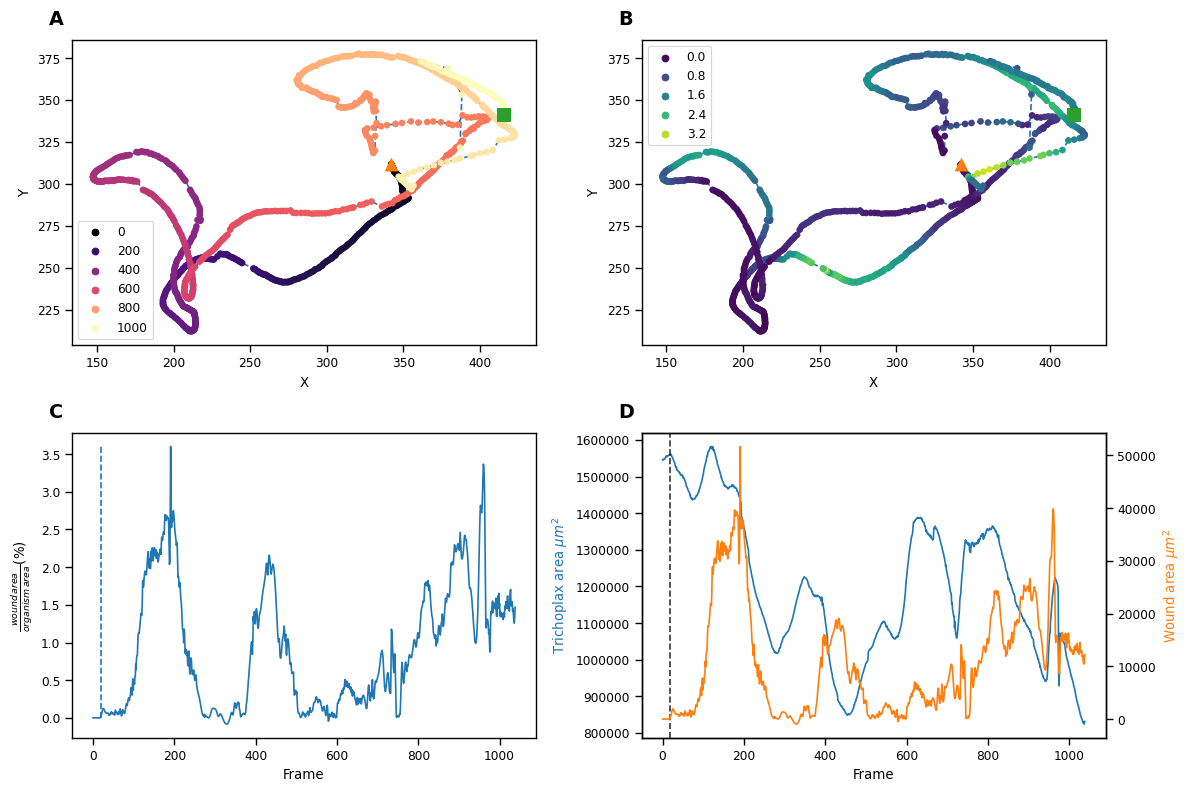

In [21]:
sns.set_context('paper') # set context for plotting

fig,ax = plt.subplots(2,2,figsize=(12,8)) # create the canvas size

# build grid
ax = ax.ravel()

# panel A

ax[0].plot(df_prepro['centroid-0'],df_prepro['centroid-1'],linestyle='--',zorder=0)

sns.scatterplot(data=df_prepro,x='centroid-0',y='centroid-1',hue=df_prepro.index.values,palette='magma',linewidth=0,zorder=1,
                hue_norm=(0,1000),ax=ax[0])

ax[0].scatter(x=df_prepro['centroid-0'].values[0],y=df_prepro['centroid-1'].values[0] 
            ,marker="^",linewidth=0,label='begining',zorder=2,s=100)

ax[0].scatter(x=df_prepro['centroid-0'].values[-1],y=df_prepro['centroid-1'].values[-1] 
            ,marker="s",linewidth=0,label='end',zorder=2,s=100)

# panel B

ax[1].plot(df_prepro['centroid-0'],df_prepro['centroid-1'],linestyle='--',zorder=0)

sns.scatterplot(data=df_prepro,x='centroid-0',y='centroid-1',hue=ratio,palette='viridis',linewidth=0,zorder=1,
                hue_norm=(min(ratio),max(ratio)),ax=ax[1])

ax[1].scatter(x=df_prepro['centroid-0'].values[0],y=df_prepro['centroid-1'].values[0] 
            ,marker="^",linewidth=0,label='begining',zorder=2,s=100)

ax[1].scatter(x=df_prepro['centroid-0'].values[-1],y=df_prepro['centroid-1'].values[-1] 
            ,marker="s",linewidth=0,label='end',zorder=2,s=100)


# panel C

ax[2].plot(ratio)
ax[2].vlines(19,0,max(ratio),linestyle='--')

# panel D

ax2 = ax[3].twinx()

sns.lineplot(x=df_prepro.index.values,y = df_prepro.area*(pixel_size)*(pixel_size),ax = ax[3],color='tab:blue')

sns.lineplot(x=df_wound.index.values,y = df_wound.area*(pixel_size)*(pixel_size), ax = ax2,color='tab:orange')

ax[3].axvline(19,0,ax[3].get_ylim()[1],linestyle='--',color='black',alpha=0.8,label='laser ablation')

ax[3].ticklabel_format(style='plain')

# Add the letter for panel

letter = ['A','B','C','D']

for i in range(4): 
    #if i != 2:
    ax[i].text(-0.05,1.05, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')
    #else:
        #ax[i].text(-0.027,1.01, letter[i], transform=ax[i].transAxes,fontsize='x-large',fontweight='bold',family='sans-serif')

# customization

ax[3].set_ylabel('Trichoplax area $\mu m^2$',color = 'tab:blue')
ax2.set_ylabel('Wound area $\mu m^2$',color='tab:orange')
ax[3].set_xlabel('Frame')

ax[0].set_ylabel('Y')
ax[1].set_ylabel('Y')

ax[0].set_xlabel('X')
ax[1].set_xlabel('X')

ax[2].set_ylabel(r"$ \frac{wound\,area}{organism\,area}$" + '(%)')
ax[2].set_xlabel('Frame')

# saving

plt.tight_layout()
#plt.savefig('../data/results/figures/report/fig4_replot.svg',dpi=300)
plt.show()